In [1]:
import sys
sys.path.append('./deep-learning-from-scratch-2')
import numpy as np
from common.layers import MatMul

%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

- Token 의 One hot vector 를 우리가 표현하려고 하는 은닉층 (Matrix) 간의 행렬곱을 활용해 one hot vector 를 다른 표현으로 바꿀 수 있다.

In [2]:
C = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(C)
print(h)

[[-0.01630367  1.29645191 -0.17361396]]


### Word2Vec: CBOW
- context(맥락)을 통해 target (중심단어)를 맞추게끔 학습하는 신경망 구조
- hidden layer 의 neuron 수 (node 수)를 입력층의 Neuron 수보다 작게 하는 것이 핵심.
- 이는 은닉층에 필요한 정보를 간결하게 담고, 밀집된 벡터 표현으로 가능하기 때문이다.
<br><br>
#### Inference
- CBOW 모델은 W_in 이라는 Matrix 를 공유
- hidden layer 는 context 단어들의 vector 의 합이므로, 평균을 취해주어야함 (2개 context -> 0.5 * )
- activation function 이 없음

In [3]:
# Word2Vec Inference

# 주변단어 Sample
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward path
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)


[[ 0.20887002  0.01975276 -0.17145521  0.11161872 -0.23538123  0.14279208
  -1.78609608]]


- 이제 이 끝 layer 에 softmax layer 와 cross entropy loss layer 를 추가하여 Loss 를 출력한다.
- 이를 backprop을 통해 W_in 과 W_out을 조정한다.
- 당연한 이야기 일 수 있겠지만, 우리의 W_in, W_out 은 우리가 가지고 있는 Corpus 에 따라서 단어에 대한 W_in 이 달라진다.

### Word2Vec을 위한 Training data 준비

In [4]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print("corpus", corpus)
print("id_to_word", id_to_word)

corpus [0 1 2 3 4 1 5 6]
id_to_word {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


- context, target pair 를 만들기 (context window : 1)<br>
ex. [0, 2] -> [1]<br>
   [1, 3] -> [2]

In [5]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [6]:
contexts, target = create_contexts_target(corpus, window_size=1)
print("contexts \n", contexts)
print("target", target)

contexts 
 [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target [1 2 3 4 1 5]


In [7]:
# One hot vector 로 바꾸기

from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print("contexts \n", contexts)
print("target", target)

contexts 
 [[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
target [[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


### 간단한 CBOW 구성

In [8]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # W_in, W_out, initialize
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # Layers
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.parmas, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = 0.5 * (h0 + h1)
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### Train: Whole Code

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

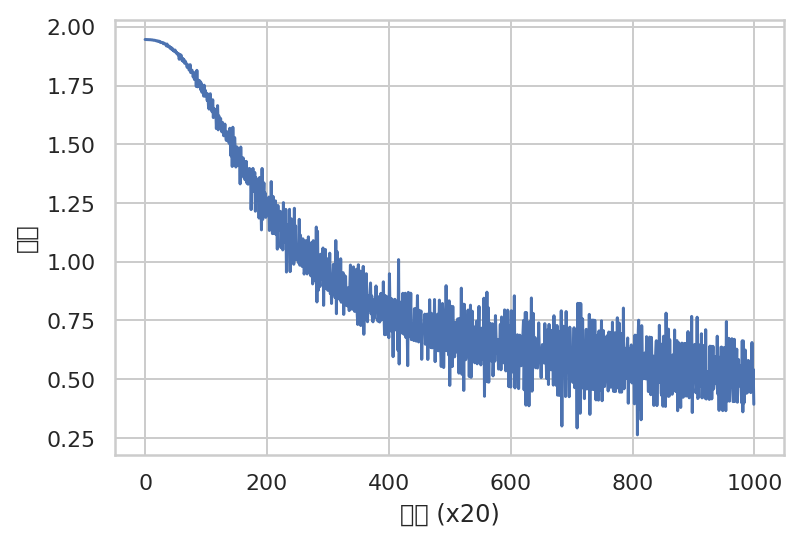

In [9]:
import sys
sys.path.append('./deep-learning-from-scratch-2/ch03')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

### 학습된 Word2Vec 확인

In [10]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.9173957   1.5403212   0.9253902  -0.98186463  1.0564241 ]
say [ 1.188836    0.27454162 -1.1966631   1.1882318  -0.27460793]
goodbye [-0.92038304  0.28307635  0.9043126  -0.83633673  0.9688187 ]
and [ 0.92359746  1.5558242  -0.9028237   0.9239463  -1.514762  ]
i [-0.9055886  0.272096   0.9037326 -0.8391818  0.9716231]
hello [-0.9094996   1.5385082   0.9331113  -0.99327207  1.0588148 ]
. [ 1.1109079 -1.3780179 -1.1089642  1.1198583  1.5727836]
